# **Un peu d'Exploratory Data Analysis avant toutes choses**

Ce notebook vise à explorer rapidement la base de données pour avoir une idée de se composition, la répartition et éventuels déséquilibres entre les classes, les caractéristiques des textes à analyser. Cela est éventuellement l'occasion de détecter des particularismes dans les messages qu'il faudra bien prendre en compte dans le preprocessing. Les principales conclusions sont :
- Labels overlapping mais équilibrés dans l'échantillon test
- Attention à l'encodage _diacritique_ des accents qui ne correspond pas à celui "du clavier azerty" (exemple : é dans le jeu de données est égale à e (U+0065)

# 1. Packages usuels et importation de la base train

In [7]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Packages classiques
import pandas as pd

# Custom package
import func_custom as fc

# NLP
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Les messages étant longs, cela permettra de visualiser un peu plus de contenu directement depuis le notebook
pd.set_option('max_colwidth', 300)

La variable `Unnamed: 0` semble juste être un indice de ligne, on peut pour le moment ne pas le garder pour l'analyse. Gardons l'encodage par défaut de `pd.read_excel` et nous étudierons cela plus tard dans le notebook.

In [10]:
df = pd.read_excel("data/data_train.xlsx",
                    usecols = ["label", "message"])

# 2. Rapides statistiques descriptives : dataframe et `label`

In [11]:
df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    700 non-null    object
 1   message  700 non-null    object
dtypes: object(2)
memory usage: 1008.4 KB


Il n'y a _a priori_ pas de valeurs nulles dans l'échantillon, vérifions le case suivante.

In [12]:
df.isna().sum()

label      0
message    0
dtype: int64

In [13]:
df.sample(3)

,label,message
92,1:8,"Bonjour, Je viens vers vous car nous avons effectué notre changement concernant notre PACS. Puis nous avons choisi un taux individualisé car nous avons un écart conséquent dans nos revenus. Maintenant j'ai un autre problème concernant mon propre taux qui est actuellement de 0000,0000%. Ce q..."
335,1,Changement de situation professionnelle - chômage Ma situation professionnelle a profondément changé depuis le 0000 juin 0000 date depuis laquelle je suis inscrite à pôle emploi. Mes revenus sont maintenant sensiblement inférieurs passant de 0000.0000 à 0000.0000 € annuels net imposables....
227,8,"bonjour, mon prélévement est indiqué à 0000.0000% et celui de mon conjoint est à 0000%. or, mes revenus de retraite sont de 0000 0000 euros et ceux de mon conjoint de 0000 0000 euros. pourquoi cette différence de taux en taux individualisé qui n'est pas proportionnel à nos revenus ? merci"


Regardons maintenant succinctement la distribution des labels

In [14]:
df["label"].value_counts()

label
8      309
1      302
1:8     89
Name: count, dtype: int64

On constate que l'échantillon est **équilibré entre les classes 1 et 8**, il n'y a pas de déséquilibres et donc les techniques de prises en charge d'_imbalanced dataset_ ne sont pas nécessaires :
- Upsampling/downsampling voire SMOTE pour augmentation synthétique
- Changement de la métrique à retenir

# 3. Exploration des `message`

Certes partie vise i) à identifier des premiers éléments à partir de l'étude brute du texte et ii) découvrir des éléments importants qu'il faudra tenir en compte dans le preprocessing

## 3.1 Métriques simples

In [15]:
# Générateur aléatoire de messages pour première inspection visuelle
df.sample(1)["message"].values[0]

"Bonjour, j'aimerais savoir comment faire pour que le prélèvement à la source du foyer soit prélevé sur mon salaire uniquement. C'est à dire que j'aimerais que ma partenaire ai un taux de 0000% et que moi subisse la totalité du prélèvement. Est ce possible ? XXXXX"

In [16]:
# Quelques fonctions simples pour caractériser les messages, et comparer d'éventuelles différences entre les labels
df["len_message"] = df["message"].apply(len)
df["count_words"] = df["message"].apply(lambda x: fc.count_words(x))

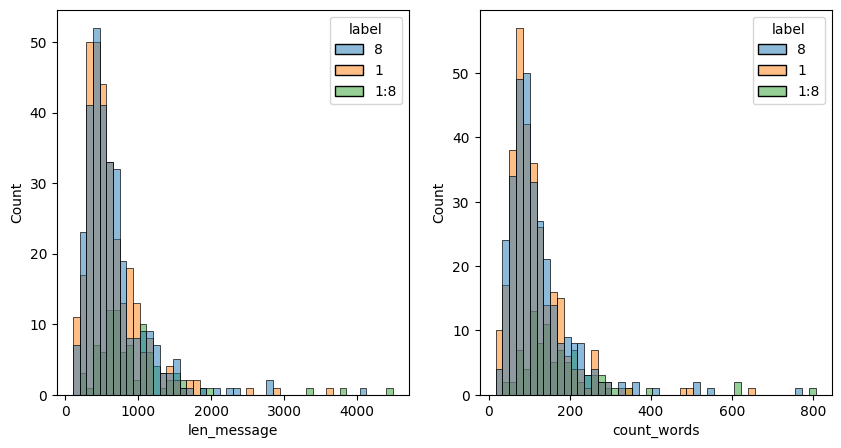

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

_ = sns.histplot(data = df,
                 ax = axes[0],
                 x = "len_message",
                 hue = "label")

_ = sns.histplot(data = df,
                 ax = axes[1],
                 x = "count_words",
                 hue = "label")

## 3.2 WordCloud (quasi) brut

In [18]:
# Concaténer tous les textes dans cette colonne en une seule chaîne de caractères
text = ' '.join(df["message"].dropna())

# Premier jeu standard de stopwords que l'on travaillera dans le notebook suivant
stopwords_french = set(stopwords.words('french'))

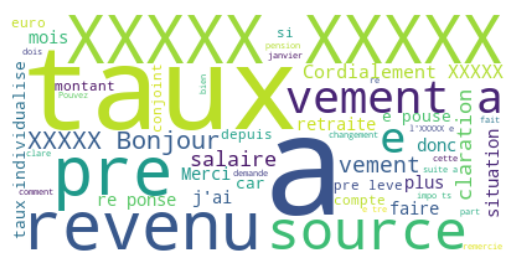

In [19]:
wordcloud = WordCloud(background_color = 'white',
                      stopwords =  stopwords_french,
                      max_words = 50).generate(text)

# Affichage du nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Sans surprise ce nuage de mot n'est pas très informatif. En plus des biais inhérent aux nuages de mots (mauvaise visualisation de l'information, biais vers les mots longs) on constate d'autres choses :
- Stopwork supplémentaires à prendre en compte (`XXXXX` issus de pseudonyamisation)
- Problème autour des accents qui scindent les mots : il faudra regarder pour la normalisation des mots avec accents

Il est déjà nécessaire de rentrer un peu plus dans le preprocessing pour prendre en compte ces spécificités et pouvoir en tirer plus d'informations, ainsi qu'être exploitable en vue du machine learning.